# Freddie Mac Mortgage Data

### Pipeline

Thomas Butler, Andrej Erkelens, Matt Suozzi

labelCol: Delinquency Status

- Downsample and Split train and test data
- StringIndexer and OneHotEncoder for categorical features
- VectorAssembler of numerical features
- StandardScalar to scale features (if necessary)
- Cross-validation to train Random Forest
- Tune Hyperparameters on train data
- Evaluate on test: Accuracy, Confusion Matrix, ROC/AUROC


In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

from pyspark.sql.functions import *
from pyspark.sql import functions as F
import pandas as pd
import numpy as np
import time

In [2]:
# Load Data
df = spark.read.parquet("/project/ds5559/Group_6_Housing/DS-5110-Final-Project/df_model_1.parquet")

In [3]:
#create binary variable for response
df = df.withColumn("label", when(df.Current_Loan_Delinquency_Status_Cat == "Past_Due", 1.0).\
                             when(df.Current_Loan_Delinquency_Status_Cat == "Deliquent",1.0).\
                            when(df.Current_Loan_Delinquency_Status_Cat == "0",0.0))
df.columns

['Current_Loan_Delinquency_Status',
 'Current_Loan_Delinquency_Status_Cat',
 'Credit_Score',
 'First_Time_Homebuyer_Flag',
 'Occupancy_Status',
 'Original_Combined_Loan-to-Value_CLTV',
 'Original_Debt-to-Income_DTI_Ratio',
 'Original_Interest_Rate',
 'Loan_Purpose',
 'Original_Loan_Term',
 'Number_of_Borrowers',
 'Loan_Age',
 'Actual_Loss_Calculation',
 'Delinquent_Accrued_Interest',
 'Remaining_Months_to_Legal_Maturity',
 'Modification_Flag',
 'Change_of_Interest_Rate',
 'label']

In [4]:
df.printSchema()

root
 |-- Current_Loan_Delinquency_Status: string (nullable = true)
 |-- Current_Loan_Delinquency_Status_Cat: string (nullable = true)
 |-- Credit_Score: integer (nullable = true)
 |-- First_Time_Homebuyer_Flag: string (nullable = true)
 |-- Occupancy_Status: string (nullable = true)
 |-- Original_Combined_Loan-to-Value_CLTV: integer (nullable = true)
 |-- Original_Debt-to-Income_DTI_Ratio: integer (nullable = true)
 |-- Original_Interest_Rate: float (nullable = true)
 |-- Loan_Purpose: string (nullable = true)
 |-- Original_Loan_Term: integer (nullable = true)
 |-- Number_of_Borrowers: string (nullable = true)
 |-- Loan_Age: integer (nullable = true)
 |-- Actual_Loss_Calculation: integer (nullable = true)
 |-- Delinquent_Accrued_Interest: integer (nullable = true)
 |-- Remaining_Months_to_Legal_Maturity: integer (nullable = true)
 |-- Modification_Flag: string (nullable = true)
 |-- Change_of_Interest_Rate: float (nullable = true)
 |-- label: double (nullable = true)



In [5]:
total = df.count()

response_cat = df.select("label").\
                groupBy('label').\
                agg(F.count('label').alias("label_count")).\
                withColumn("Percent", col('label_count')/total*100)

response_cat.show()

+-----+-----------+-----------------+
|label|label_count|          Percent|
+-----+-----------+-----------------+
|  0.0|    4152122|94.12775245309847|
|  1.0|     259034|5.872247546901538|
+-----+-----------+-----------------+



In [6]:
from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MaxAbsScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

### Create Pipeline with Transformers


In [7]:
seed = 314
train_test = [0.5,0.5]
train, test = df.randomSplit(train_test, seed)

frac=train.filter(train.label==1).count()/train.filter(train.label==0).count()

train = train.sampleBy("label", fractions={0:frac, 1:1}, seed=seed)

# Use smaller subset to test code
sample = df.sampleBy("label", fractions={0: 0.05, 1: 0.05}, seed=seed)
holdout = df.subtract(sample)

In [8]:
from pyspark.sql.types import IntegerType


df = df.withColumn("Number_of_Borrowers",df["Number_of_Borrowers"].cast(IntegerType()))
df = df.withColumn("label",df["label"].cast(IntegerType()))

In [9]:
df.printSchema()

root
 |-- Current_Loan_Delinquency_Status: string (nullable = true)
 |-- Current_Loan_Delinquency_Status_Cat: string (nullable = true)
 |-- Credit_Score: integer (nullable = true)
 |-- First_Time_Homebuyer_Flag: string (nullable = true)
 |-- Occupancy_Status: string (nullable = true)
 |-- Original_Combined_Loan-to-Value_CLTV: integer (nullable = true)
 |-- Original_Debt-to-Income_DTI_Ratio: integer (nullable = true)
 |-- Original_Interest_Rate: float (nullable = true)
 |-- Loan_Purpose: string (nullable = true)
 |-- Original_Loan_Term: integer (nullable = true)
 |-- Number_of_Borrowers: integer (nullable = true)
 |-- Loan_Age: integer (nullable = true)
 |-- Actual_Loss_Calculation: integer (nullable = true)
 |-- Delinquent_Accrued_Interest: integer (nullable = true)
 |-- Remaining_Months_to_Legal_Maturity: integer (nullable = true)
 |-- Modification_Flag: string (nullable = true)
 |-- Change_of_Interest_Rate: float (nullable = true)
 |-- label: integer (nullable = true)



In [10]:
# Transform features

# Bucketize FICO scores into categories
splits = [300, 580, 670, 740, 800, 850]
bucketizer = Bucketizer(splits=splits, inputCol="Credit_Score", outputCol="Credit_Score_Groups")

# Transform Categorical variables into dummy variables using StringIndexer and OneHotEncoder
stringIndexer_HF = StringIndexer(inputCol="First_Time_Homebuyer_Flag", outputCol="First_Time_Homebuyer_Flag_Index")
encoder_HF = OneHotEncoder(inputCol="First_Time_Homebuyer_Flag_Index", outputCol="First_Time_Homebuyer_Flag_Vec")

stringIndexer_LP = StringIndexer(inputCol="Loan_Purpose", outputCol="Loan_Purpose_Index")
encoder_LP = OneHotEncoder(inputCol="Loan_Purpose_Index", outputCol="Loan_Purpose_Vec")

stringIndexer_OS = StringIndexer(inputCol="Occupancy_Status", outputCol="Occupancy_Status_Index")
encoder_OS = OneHotEncoder(inputCol="Occupancy_Status_Index", outputCol="Occupancy_Status_Vec")

In [11]:
# Assemble features
numericCols = ["Original_Combined_Loan-to-Value_CLTV", "Original_Debt-to-Income_DTI_Ratio", "Original_Interest_Rate"]
indexCategoricalCols = ["Credit_Score_Groups","First_Time_Homebuyer_Flag_Index", "Loan_Purpose_Index", "Occupancy_Status_Index"]
categoricalCols = ["Credit_Score_Groups", "First_Time_Homebuyer_Flag_Vec", "Loan_Purpose_Vec","Occupancy_Status_Vec"]

# no scaling, no OHE
assemblerInputs_simple = numericCols + indexCategoricalCols
assembler_simple = VectorAssembler(inputCols=assemblerInputs_simple, outputCol="features")

# no scaling, with OHE
assemblerInputs_mix = numericCols + categoricalCols
assembler_mix = VectorAssembler(inputCols=assemblerInputs_mix, outputCol="features_OHE")

In [12]:
# With scaled the assembled numerical features and OHE
assembler_num = VectorAssembler(inputCols=numericCols, outputCol="features")
std = StandardScaler(inputCol='features',outputCol='scaled_features')
assemblerInputs_full = ['scaled_features'] + categoricalCols
assembler_full = VectorAssembler(inputCols=assemblerInputs_full, outputCol='features_full')

In [13]:
# Define Random Forest Model
gbt1 = GBTClassifier(labelCol='label', featuresCol="features", maxBins=10, seed=seed)

gbt2 = GBTClassifier(labelCol='label', featuresCol="features_OHE", maxBins=10, seed=seed)

gbt3 = GBTClassifier(labelCol='label', featuresCol="features_full", maxBins=10, seed=seed)

In [14]:
# Set up pipelines
# no scaling, no OHE
pipeline_gbt1 = Pipeline(stages=[bucketizer, stringIndexer_HF, stringIndexer_LP, stringIndexer_OS,assembler_simple, gbt1])

# no scaling with OHE
pipeline_gbt2 = Pipeline(stages=[bucketizer, stringIndexer_HF, encoder_HF, stringIndexer_LP,encoder_LP, stringIndexer_OS,encoder_OS, assembler_mix, gbt2])

# scaling and OHE
pipeline_gbt3 = Pipeline(stages=[bucketizer, stringIndexer_HF, encoder_HF, stringIndexer_LP,encoder_LP, stringIndexer_OS,encoder_OS, assembler_num,std,assembler_full, gbt3])

In [15]:
# Evaluator
eval_gbt = BinaryClassificationEvaluator()

### Train and Evaluate Model

Train and test using each pipeline to see if using one hot encoding and scaled numerical variables improves the model.

In [ ]:
# no scaling, no OHE
m1_start = time.time()
model_gbt1 = pipeline_gbt1.fit(train)
m1_end = time.time()
m1_time = m1_end-m1_start
print('Total time for training was ' + str(m1_time))

In [ ]:
pred_gbt1 = model_gbt1.transform(test)

In [ ]:
pred_gbt1.select('label','features','prediction', 'probability').show(5, truncate=False)

In [ ]:
#Best AROC
print('Best Test AUROC: ', eval_gbt.evaluate(pred_gbt1))

In [ ]:
model_gbt1.stages[-1].params

In [ ]:
# no scaling, with OHE
m1_start = time.time()
model_gbt2 = pipeline_gbt2.fit(train)
m1_end = time.time()
m1_time = m1_end-m1_start
print('Total time for training was ' + str(m1_time))

In [ ]:
pred_gbt2 = model_gbt2.transform(test)

In [ ]:
#Best AROC
print('Best Test AUROC: ', eval_gbt.evaluate(pred_gbt2))

In [ ]:
# scaling & OHE
m1_start = time.time()
model_gbt3 = pipeline_gbt3.fit(train)
m1_end = time.time()
m1_time = m1_end-m1_start
print('Total time for training was ' + str(m1_time))

In [ ]:
pred_gbt3 = model_gbt3.transform(test)

In [ ]:
#Best AROC
print('Best Test AUROC: ', eval_gbt.evaluate(pred_gbt3))

### Train using Cross-Validation

Train and test using the mix pipeline since that performed well in the fastest time.

(*, featuresCol='features', labelCol='label', predictionCol='prediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, lossType='logistic', maxIter=20, stepSize=0.1, seed=None, subsamplingRate=1.0, impurity='variance', featureSubsetStrategy='all', validationTol=0.01, validationIndicatorCol=None, leafCol='', minWeightFractionPerNode=0.0, weightCol=None)[source]

In [ ]:
# Cross-validation - RF
grid_gbt1 = (ParamGridBuilder().addGrid(gbt1.maxDepth, [2,5,10]). addGrid(gbt1.subsamplingRate, [1.0, .5, .2]).
             addGrid(gbt1.featureSubsetStrategy,['all','sqrt']).addGrid(gbt1.stepSize,[.01,.1]).build())

In [ ]:
#cvRF = CrossValidator(estimator=rf, evaluator=evalRF, estimatorParamMaps=gridRF, numFolds=10, seed=seed).setParallelism(4)

cv_gbt1 = CrossValidator(estimator=pipeline_gbt1, evaluator=eval_gbt, estimatorParamMaps=grid_gbt1, numFolds=10, seed=seed).setParallelism(4)


In [ ]:
m1_start = time.time()
cv_gbt = cv_gbt1.fit(train)
m1_end = time.time()
m1_time = m1_end-m1_start
print('Total time for training with 4 parallel processors was ' + str(m1_time))

In [ ]:
path = "/project/ds5559/Group_6_Housing/DS-5110-Final-Project/model_2_gbt/gbtc"

cv_gbt.write().overwrite().save(path)

In [ ]:
bestModel = cv_gbt.bestModel

In [ ]:
bestModel.getThresholds()

In [ ]:
bestModel.stages

In [ ]:
gbt_best = bestModel.transform(test)

In [ ]:
gbt_best.summary

#Best AUROC
print('Best Test AUROC: ', evalRF.evaluate(predRF_best))

In [41]:
bestModel.stages[-1].extractParamMap()

{Param(parent='GBTClassifier_ab4d2fe584b1', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='GBTClassifier_ab4d2fe584b1', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='GBTClassifier_ab4d2fe584b1', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for r

In [42]:
print(bestModel.stages[-1])

GBTClassificationModel: uid = GBTClassifier_ab4d2fe584b1, numTrees=20, numClasses=2, numFeatures=7


In [47]:
bestModel.stages[-1].thresholds

Param(parent='GBTClassifier_ab4d2fe584b1', name='thresholds', doc="Thresholds in multi-class classification to adjust the probability of predicting each class. Array must have length equal to the number of classes, with values > 0, excepting that at most one value may be 0. The class with largest value p/t is predicted, where p is the original probability of that class and t is the class's threshold.")

In [48]:
#Best AUROC
print('Best Test AUROC: ', eval_gbt.evaluate(gbt_best))

Best Test AUROC:  0.7175478572582471


In [49]:
#Evaluate Accuracy and Confusion Matrix on test matrix

from pyspark.mllib.evaluation import MulticlassMetrics

temp = gbt_best.select("probability", "label")

def round_thres(num):
    if num >= .5:
        return 1.0
    else:
        return 0.0
                       
predsAndLabels = temp.rdd.map(lambda p: (round_thres(float(p.probability[1])),p.label))

metrics = MulticlassMetrics(predsAndLabels)

print('model accuracy: ' + str(metrics.accuracy))

print('model precision: ' + str(metrics.precision(1.0)))
print('model recall: ' + str(metrics.recall(1.0)))

print('model F-Score: ' + str(metrics.fMeasure(0.0, 1.0)))

con_matrix = metrics.confusionMatrix().toArray()
print(con_matrix)

#Maximize Negative Predictive value NPV
NPV = con_matrix[0][0]/(con_matrix[0][0]+con_matrix[1][0])
print("Negative Predictive Value: " + str(NPV))

model accuracy: 0.656999451122977
model precision: 0.10814717460587155
model recall: 0.6686466403528422
model F-Score: 0.7827088165487807
[[1362988.  713872.]
 [  42898.   86565.]]
Negative Predictive Value: 0.9694868573981105


---

<b> ROC Curve Calculation </b>


In [51]:
x1 = []
y1 = []


def round_thres(num):
    if num >= 0.25:
        return 1.0
    else:
        return 0.0
                       
predsAndLabels = temp.rdd.map(lambda p: (round_thres(float(p.probability[1])),p.label))

metrics = MulticlassMetrics(predsAndLabels)

x1.append(metrics.falsePositiveRate(1.0))
y1.append(metrics.truePositiveRate(1.0))

In [52]:
#Evaluate Accuracy and Confusion Matrix on test matrix
def round_thres(num):
    if num >= .45:
        return 1.0
    else:
        return 0.0
                       
predsAndLabels = temp.rdd.map(lambda p: (round_thres(float(p.probability[1])),p.label))

metrics = MulticlassMetrics(predsAndLabels)

print('model accuracy: ' + str(metrics.accuracy))

print('model precision: ' + str(metrics.precision(1.0)))

print('model F-Score: ' + str(metrics.fMeasure(0.0, 1.0)))

x1.append(metrics.falsePositiveRate(1.0))
y1.append(metrics.truePositiveRate(1.0))

con_matrix = metrics.confusionMatrix().toArray()
print(con_matrix)

#Maximize Negative Predictive value NPV
NPV = con_matrix[0][0]/(con_matrix[0][0]+con_matrix[1][0])
print("Negative Predictive Value: " + str(NPV))

model accuracy: 0.5821944475038333
model precision: 0.09807333129753645
model F-Score: 0.720449966216749
[[1187839.  889021.]
 [  32793.   96670.]]
Negative Predictive Value: 0.9731344090602245


In [53]:
def round_thres(num):
    if num >= 0.5:
        return 1.0
    else:
        return 0.0
                       
predsAndLabels = temp.rdd.map(lambda p: (round_thres(float(p.probability[1])),p.label))

metrics = MulticlassMetrics(predsAndLabels)

print('model accuracy: ' + str(metrics.accuracy))

print('model precision: ' + str(metrics.precision(1.0)))

print('model F-Score: ' + str(metrics.fMeasure(0.0, 1.0)))

x1.append(metrics.falsePositiveRate(1.0))
y1.append(metrics.truePositiveRate(1.0))

con_matrix = metrics.confusionMatrix().toArray()
print(con_matrix)

#Maximize Negative Predictive value NPV
NPV = con_matrix[0][0]/(con_matrix[0][0]+con_matrix[1][0])
print("Negative Predictive Value: " + str(NPV))

model accuracy: 0.656999451122977
model precision: 0.10814717460587155
model F-Score: 0.7827088165487807
[[1362988.  713872.]
 [  42898.   86565.]]
Negative Predictive Value: 0.9694868573981105


In [54]:
def round_thres(num):
    if num >= 1-.44:
        return 1.0
    else:
        return 0.0

predsAndLabels = temp.rdd.map(lambda p: (round_thres(float(p.probability[1])),p.label))

metrics = MulticlassMetrics(predsAndLabels)

print('model accuracy: ' + str(metrics.accuracy))

print('model precision: ' + str(metrics.precision(1.0)))

print('model F-Score: ' + str(metrics.fMeasure(0.0, 1.0)))

x1.append(metrics.falsePositiveRate(1.0))
y1.append(metrics.truePositiveRate(1.0))

con_matrix = metrics.confusionMatrix().toArray()
print(con_matrix)

#Maximize Negative Predictive value NPV
NPV = con_matrix[0][0]/(con_matrix[0][0]+con_matrix[1][0])
print("Negative Predictive Value: " + str(NPV))

model accuracy: 0.7324707216486435
model precision: 0.12152339149104636
model F-Score: 0.839361469352031
[[1542090.  534770.]
 [  55486.   73977.]]
Negative Predictive Value: 0.9652686319774458


In [55]:
def round_thres(num):
    if num >= 0.75:
        return 1.0
    else:
        return 0.0
                       
predsAndLabels = temp.rdd.map(lambda p: (round_thres(float(p.probability[1])),p.label))

metrics = MulticlassMetrics(predsAndLabels)

x1.append(metrics.falsePositiveRate(1.0))
y1.append(metrics.truePositiveRate(1.0))

In [56]:
def round_thres(num):
    if num >= 0.85:
        return 1.0
    else:
        return 0.0
                       
predsAndLabels = temp.rdd.map(lambda p: (round_thres(float(p.probability[1])),p.label))

metrics = MulticlassMetrics(predsAndLabels)

x1.append(metrics.falsePositiveRate(1.0))
y1.append(metrics.truePositiveRate(1.0))

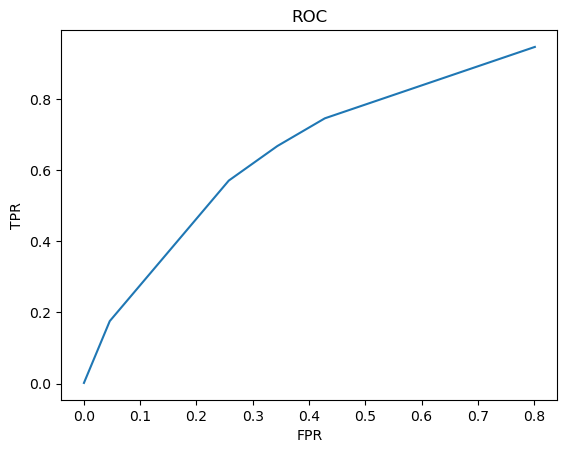

In [57]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(x1, y1)
plt.show()